# Loading libraries

In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Data Description

In [315]:
df=pd.read_csv('ev_battery_data.csv')
df.head(3)

,State_of_Charge (%),Cycle_Count,Temperature (°C),Voltage (V),Current (A),Health_Status
0,47.85,884,37.44,3.27,17.58,mid
1,33.90,1262,57.42,3.08,28.96,risk
2,17.51,1039,46.85,2.84,28.62,risk


In [316]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   State_of_Charge (%)  950 non-null    float64
 1   Cycle_Count          1000 non-null   int64  
 2   Temperature (°C)     950 non-null    float64
 3   Voltage (V)          950 non-null    float64
 4   Current (A)          950 non-null    float64
 5   Health_Status        1000 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 47.0+ KB


In [317]:
cols=list(df.columns)
cat_cols=df.select_dtypes(include=['object']).columns.tolist()
num_cols=df.select_dtypes(exclude=['object']).columns.tolist()

print("total cols :",cols)
print("cat cols :",cat_cols)
print("num cols :",num_cols)

total cols : ['State_of_Charge (%)', 'Cycle_Count', 'Temperature (°C)', 'Voltage (V)', 'Current (A)', 'Health_Status']
cat cols : ['Health_Status']
num cols : ['State_of_Charge (%)', 'Cycle_Count', 'Temperature (°C)', 'Voltage (V)', 'Current (A)']


# CHECK for IMBALANCE

In [318]:
df['Health_Status'].value_counts()

Health_Status
good    365
mid     347
risk    288
Name: count, dtype: int64

In [319]:
# data appears balanced ,so no need to handle imabalancy

# Data cleaning

In [320]:
df.isna().sum()

State_of_Charge (%)    50
Cycle_Count             0
Temperature (°C)       50
Voltage (V)            50
Current (A)            50
Health_Status           0
dtype: int64

In [321]:
nan_cols = [i for i in cols if df[i].isnull().any()]

In [322]:
nan_cols

['State_of_Charge (%)', 'Temperature (°C)', 'Voltage (V)', 'Current (A)']

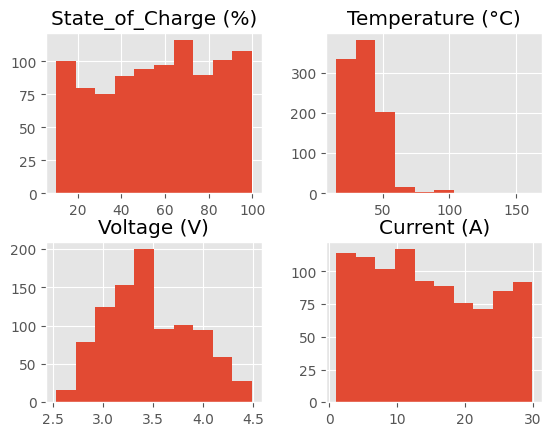

In [323]:
plt.style.use('ggplot')
df[nan_cols].hist()
plt.show()

In [324]:

df['State_of_Charge (%)']=df['State_of_Charge (%)'].fillna(df['State_of_Charge (%)'].mean())
df['Temperature (°C)']=df['Temperature (°C)'].fillna(df['Temperature (°C)'].median())
df['Voltage (V)']=df['Voltage (V)'].fillna(df['Voltage (V)'].median())
df['Current (A)']=df['Current (A)'].fillna(df['Current (A)'].mean())


In [325]:
df.isnull().sum()

State_of_Charge (%)    0
Cycle_Count            0
Temperature (°C)       0
Voltage (V)            0
Current (A)            0
Health_Status          0
dtype: int64

# EDA

<Figure size 1000x800 with 0 Axes>

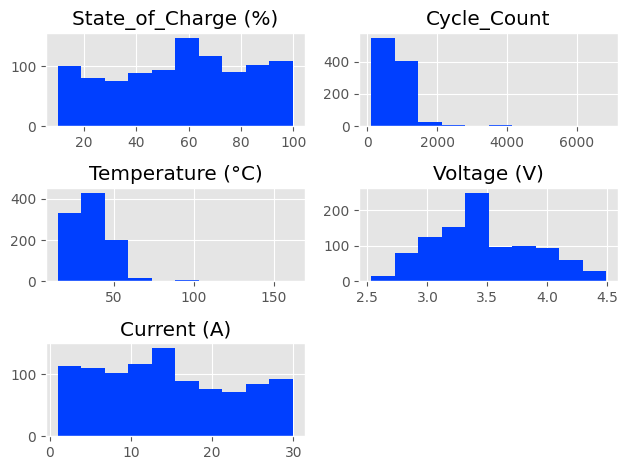

In [326]:
plt.figure(figsize=(10,8))
plt.style.use('seaborn-v0_8-bright')
df[cols].hist()
plt.tight_layout()
plt.show()

In [327]:
x=df.drop(['Health_Status'],axis=1)
y=df['Health_Status']

In [328]:
x.describe().loc[['min', '25%', '50%', '75%', 'max']]

,State_of_Charge (%),Cycle_Count,Temperature (°C),Voltage (V),Current (A)
min,10.060000,104.00,15.1100,2.5300,1.0000
25%,36.312500,371.75,25.7150,3.1575,7.6375
50%,56.842147,697.00,34.2700,3.4250,14.2850
75%,77.457500,1075.25,43.5925,3.7600,21.2000
max,99.910000,6843.00,162.1100,4.4900,29.9600


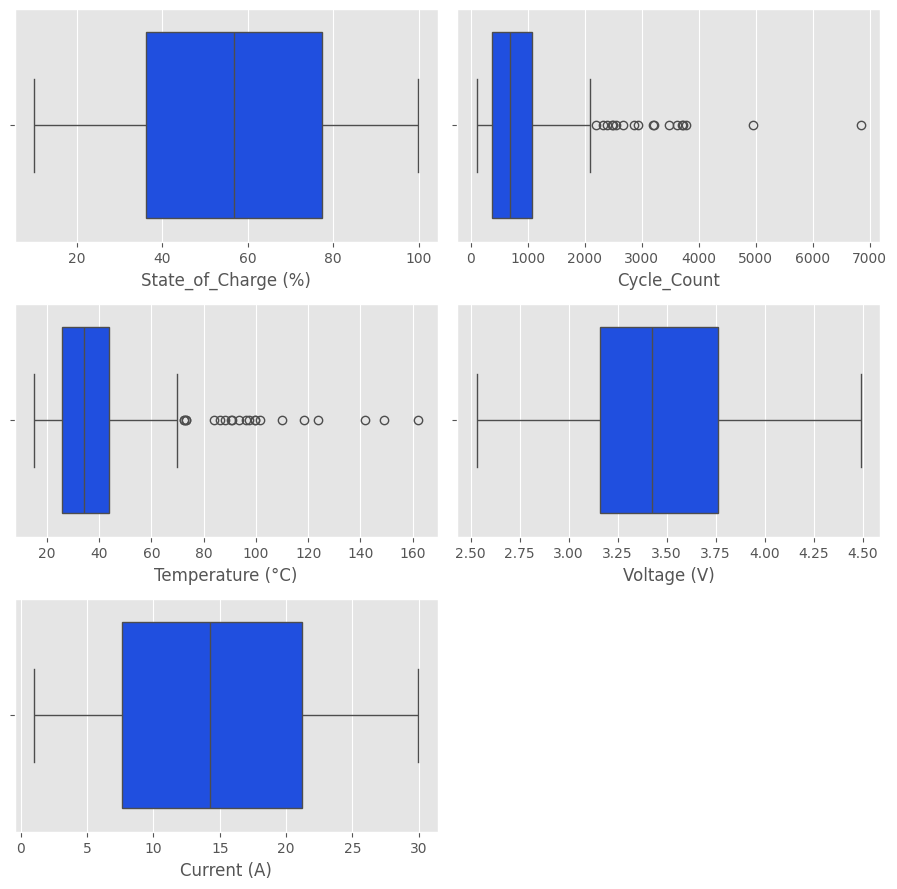

In [329]:
i=1
plt.figure(figsize=(9,9))

for col in x.columns:
    plt.subplot(3,2,i)
    sns.boxplot(x=x[col])
    plt.xlabel(col)
    i=i+1
plt.tight_layout()
plt.show()

In [330]:
# we have no outlires in current,voltage,soc

# but we have in case of temperature and cycle count
# 1. for temp values are less ,we can leave it as it is
# 2. also cycle count is something which may have outliers and can play role in detrming quality of battery and will have more bias

<Axes: xlabel='Cycle_Count'>

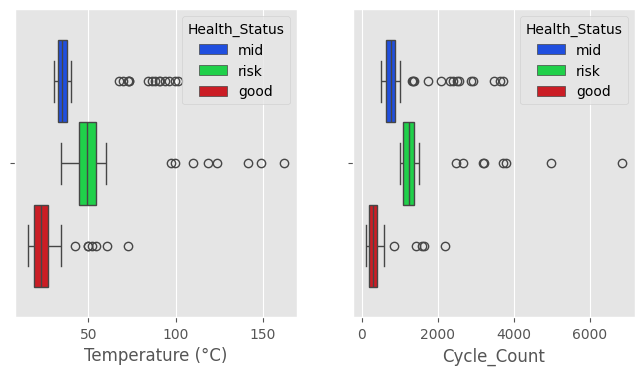

In [331]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
sns.boxplot(x=x['Temperature (°C)'],hue=y)
plt.subplot(1,2,2)
sns.boxplot(x=x['Cycle_Count'],hue=y)

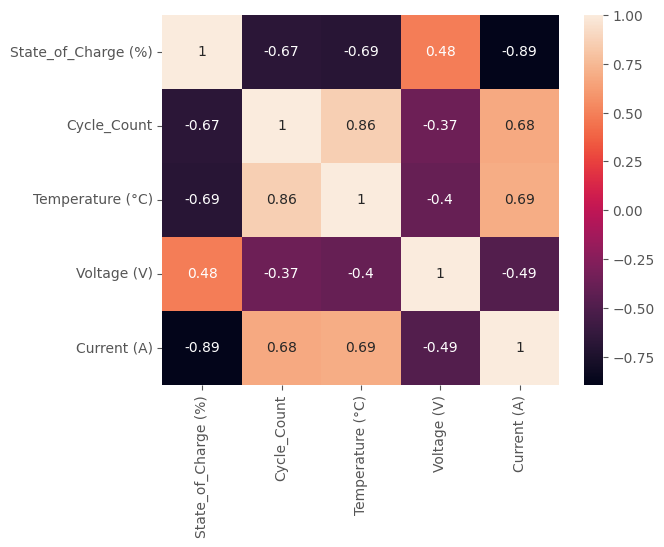

In [332]:

sns.heatmap(x.corr(),annot=True)
plt.show()

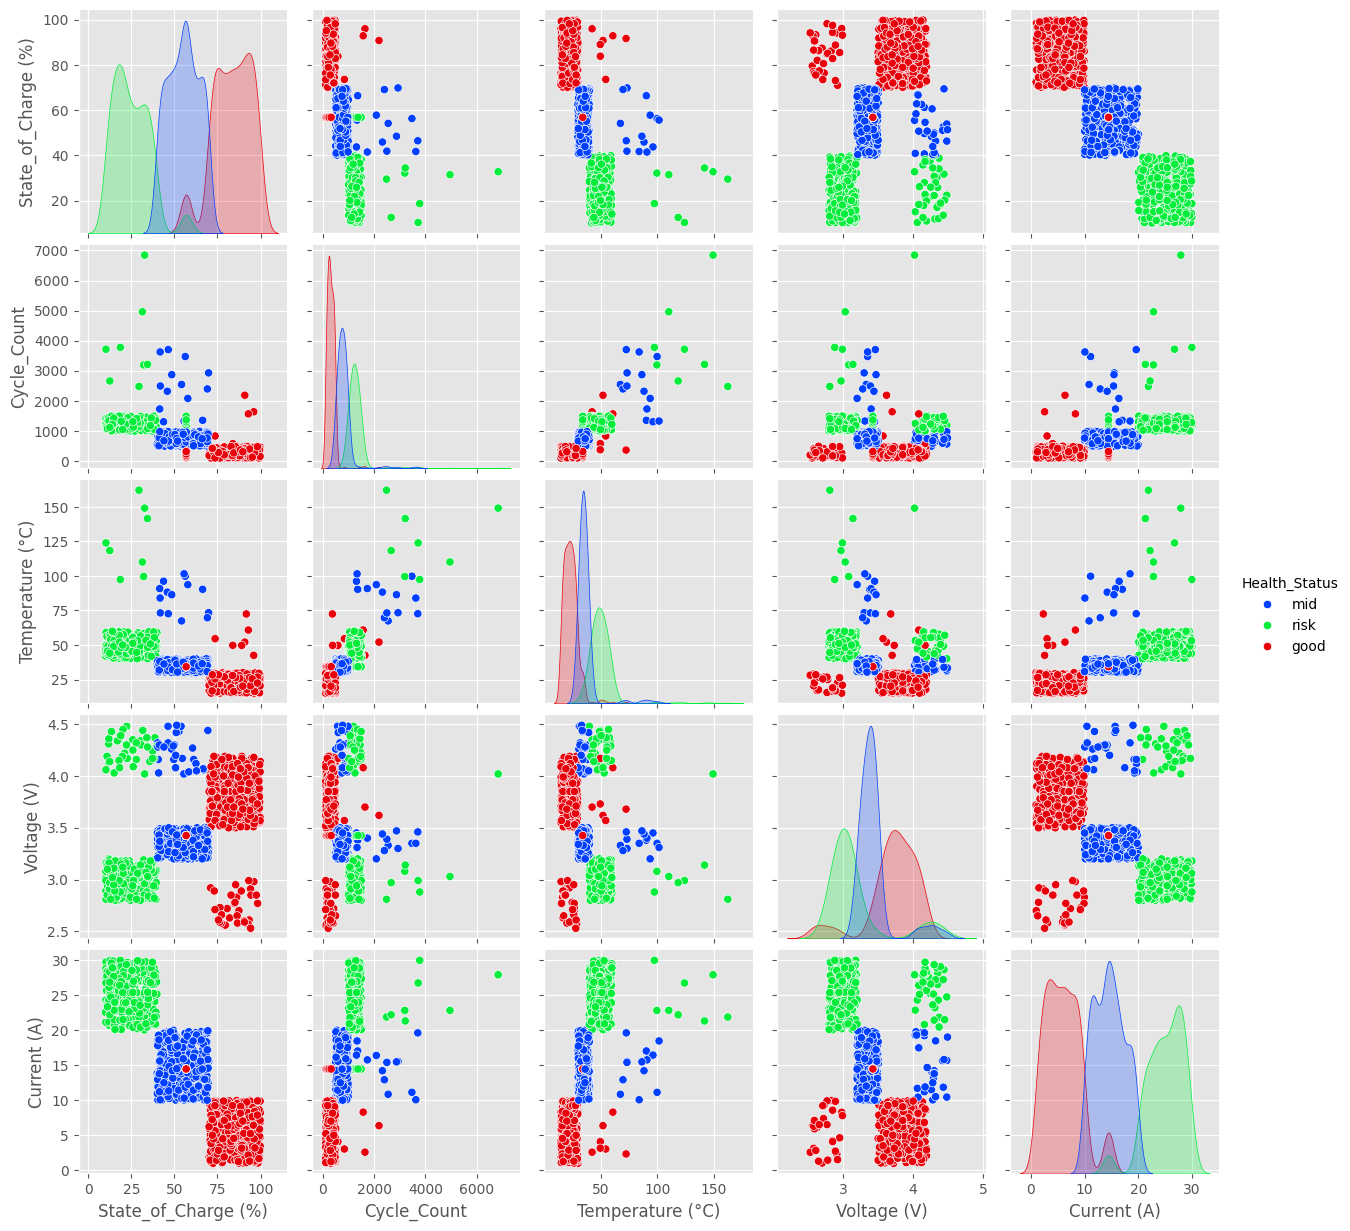

In [333]:
sns.pairplot(data=df,hue='Health_Status')
plt.show()

In [334]:
# Here data is seperable and hence algos like
# 1. SVC 
# 2. Random Forest
# can be implemented

#  Feature Engineering

In [335]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [336]:

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=42)

In [337]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((750, 5), (250, 5), (750,), (250,))

In [338]:
scalar=StandardScaler()


In [339]:
x_train_sc=scalar.fit_transform(x_train)
x_test_sc=scalar.transform(x_test)

# CV AND Hyper paramter Tuning

In [340]:
from sklearn.model_selection import StratifiedKFold
CV=StratifiedKFold(n_splits=5)

In [341]:
from sklearn.model_selection import GridSearchCV

In [342]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [343]:
svc_param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf' ,'linear','poly']}  


rfc_param_grid = { 
    'n_estimators': [25, 50, 100, 150], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [3, 6, 9], 
    'max_leaf_nodes': [3, 6, 9], 
} 



In [344]:
svc_grid.best_params_

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}

In [345]:
def trainModel ( model,param_grid):
    grid=GridSearchCV(estimator=model,param_grid=param_grid,refit=True,cv=CV,scoring='accuracy')
    grid.fit(x_train_sc,y_train)
    return grid


    

In [346]:
svc=trainModel(SVC(),svc_param_grid)

In [347]:
svc

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='accuracy')

In [348]:
rfc=trainModel(RandomForestClassifier(),rfc_param_grid)

In [349]:
rfc

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [3, 6, 9],
                         'n_estimators': [25, 50, 100, 150]},
             scoring='accuracy')

# Evalutaion

In [350]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix


    


In [361]:
def evaluateModel(grid):
    print(f"--------------------{grid.estimator}---------------------")

    print("best params :" ,grid.best_params_)
    y_pred=grid.predict(x_test_sc)
    print("Accuracy : ",accuracy_score(y_test,y_pred))    
    cr=classification_report(y_test,y_pred,)
    print("classification_report")
    print(cr)
    sns.heatmap(confusion_matrix(y_test,y_pred),annot=True)
    plt.show()

--------------------SVC()---------------------
best params : {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Accuracy :  0.996
classification_report
              precision    recall  f1-score   support

        good       1.00      0.99      0.99        95
         mid       1.00      1.00      1.00        90
        risk       0.98      1.00      0.99        65

    accuracy                           1.00       250
   macro avg       0.99      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



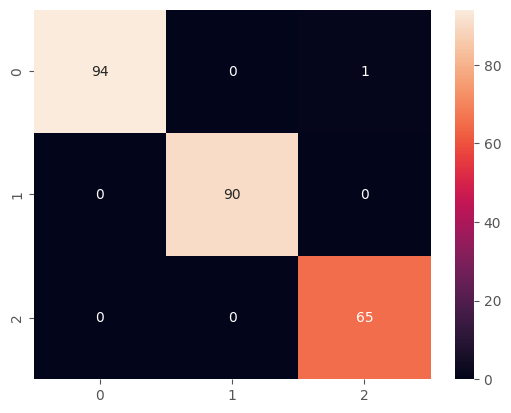

In [362]:
evaluateModel(svc)

--------------------RandomForestClassifier()---------------------
best params : {'max_depth': 6, 'max_features': 'sqrt', 'max_leaf_nodes': 6, 'n_estimators': 25}
Accuracy :  1.0
classification_report
              precision    recall  f1-score   support

        good       1.00      1.00      1.00        95
         mid       1.00      1.00      1.00        90
        risk       1.00      1.00      1.00        65

    accuracy                           1.00       250
   macro avg       1.00      1.00      1.00       250
weighted avg       1.00      1.00      1.00       250



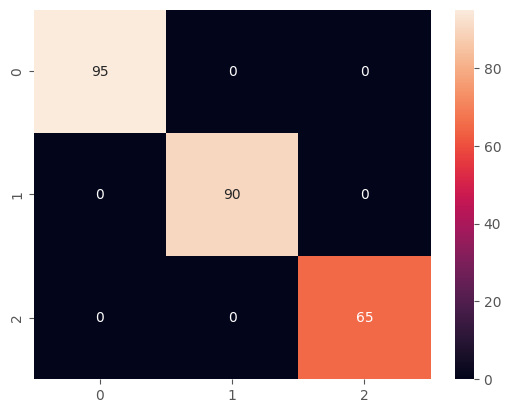

In [363]:
evaluateModel(rfc)

# Saving models

In [366]:
import joblib

In [370]:
joblib.dump(scalar,"./models/scalar.pkl")

['./models/scalar.pkl']

In [371]:
joblib.dump(svc.best_estimator_,"./models/svc_model.pkl")

['./models/svc_model.pkl']

In [372]:
joblib.dump(rfc.best_estimator_,"./models/rfc_model.pkl")

['./models/rfc_model.pkl']

# So we came to conclusion and trained ml model for battery quality classifcation